# Exercises:

- In this analysis, we use four different data sources. Load the monthly Fama-French 3-factor returns, the monthly q-factor returns from Hou, Xue, and Zhang (2014), the macroeconomic predictors from Welch and Goyal (2008), and monthly portfolio returns from 10 different industries according to the definition from Kenneth French’s homepage as test assets. Your data should contain 22 columns of regressors with 13 macro variables and 8-factor returns for each month.
- Provide meaningful summary statistics for the test assets’ excess returns.

- Familiarize yourself with the scikit-learn workflow. First, restrict yourself to just one industry, e.g. Manufacturing. Use the function train_test_split to split the sample into a training and a test set.
- Preprocess the data with ColumnTransformer which performs the following steps: First, the aim is to explain the industry excess returns as a function of all predictors. Exclude the column month from the analysis. Include all interaction terms between factors and macroeconomic predictors. Demean and scale each regressor such that the standard deviation is one.
- Build a model ElasticNet with sklearn.linear_model with a fixed penalty term that performs lasso regression. Create a Pipeline that first applies the recipe steps to the training data and then fits the model. Illustrate the predicted industry returns for the in-sample and the out-of-sample period.
- Next, tune the model such that the penalty term is flexibly chosen by cross-validation. For that purpose, update the model such that both, penalty and mixture are flexible tuning variables. Use the function TimeSeriesSplit to generate a time series cross-validation sample which allows tuning the model with 20 random samples of length five years with a validation period of four years. Tune the model for a grid of possible penalty and mixture values and visualize the mean-squared prediction errors for the industry returns across the range of possible tuning parameters.
- Finally, write a function to parallelize the entire workflow. The function should split the data into a training and test set, create a cross-validation scheme, and tunes a lasso model for different penalty values. Finally, select the best model in terms of MSPE in the validation test set. Apply the function to every individual industry and illustrate for each industry which factor and macroeconomic variables are selected by the Lasso.

In [ ]:
# install seaborn
!pip install seaborn

In [88]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split

#
import seaborn as sns
import matplotlib.pyplot as plt

#
from plotnine import *
from mizani.formatters import percent_format, date_format
from mizani.breaks import date_breaks

path_to_db = r'/Users/asbjornfyhn/Desktop/Emp Fin/data'

In [3]:
# 
tidy_finance_python = sqlite3.connect( database=f"{path_to_db}/tidy_finance_python.sqlite",)

# select all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", tidy_finance_python)
print(tables['name'].values)


['trace_enhanced' 'crsp_daily' 'factors_ff3_monthly' 'factors_ff5_monthly'
 'factors_ff3_daily' 'industries_ff_monthly' 'factors_q_monthly'
 'macro_predictors' 'cpi_monthly' 'fisd' 'compustat' 'crsp_monthly' 'beta']


In [16]:
# Fama French 3 factors
ff3_predictors = (pd.read_sql_query(
    sql="SELECT * FROM factors_ff3_monthly",
    con=tidy_finance_python,
    parse_dates={"month"})
 .add_prefix("ff3_")
)

qFactors_predictors = (pd.read_sql_query(
    sql="SELECT * FROM factors_q_monthly",
    con=tidy_finance_python,
    parse_dates={"month"})
 .add_prefix("qfactor_")
)

macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance_python,
    parse_dates={"month"})
 .add_prefix("macro_")
)

ind_ret_predictors = (pd.read_sql_query(
    sql="SELECT * FROM industries_ff_monthly",
    con=tidy_finance_python,
    parse_dates={"month"})
 .melt(id_vars="month", var_name="industry", value_name="ret")
)


In [20]:
data = (ff3_predictors
    .merge(qFactors_predictors, how="outer", left_on="ff3_month", right_on="qfactor_month")
    .merge(macro_predictors, how="outer", left_on="ff3_month", right_on="macro_month")
    .merge(ind_ret_predictors, how="outer", left_on="ff3_month", right_on="month")
    .assign(ret_excess=lambda x: x["ret"] - x["ff3_rf"])
    .drop(columns=["qfactor_month", "macro_month"])
    .rename(columns={"ff3_month": "month"})
    .dropna(how="any")
)
print(data.head(5))

         month  ff3_mkt_excess  ff3_smb  ff3_hml  ff3_rf  qfactor_me  \
840 1967-01-01          0.0815   0.0832   0.0227  0.0043   -0.021769   
841 1967-01-01          0.0815   0.0832   0.0227  0.0043   -0.021769   
842 1967-01-01          0.0815   0.0832   0.0227  0.0043   -0.021769   
843 1967-01-01          0.0815   0.0832   0.0227  0.0043   -0.021769   
844 1967-01-01          0.0815   0.0832   0.0227  0.0043   -0.021769   

     qfactor_ia  qfactor_roe  qfactor_eg  macro_dp  ...  macro_tbl  macro_lty  \
840   -0.021769    -0.021769   -0.021769 -3.403625  ...     0.0472     0.0448   
841   -0.021769    -0.021769   -0.021769 -3.403625  ...     0.0472     0.0448   
842   -0.021769    -0.021769   -0.021769 -3.403625  ...     0.0472     0.0448   
843   -0.021769    -0.021769   -0.021769 -3.403625  ...     0.0472     0.0448   
844   -0.021769    -0.021769   -0.021769 -3.403625  ...     0.0472     0.0448   

     macro_ltr  macro_tms  macro_dfy  macro_infl      month  industry     ret  \

In [21]:
print(f'Data consist of {data.shape[0]} rows and {data.shape[1]} columns with {macro_predictors.shape[1]-1} macro regressors and {data.shape[1]-(macro_predictors.shape[1]-1) - 1} factor returns')

Data consist of 6720 rows and 26 columns with 13 macro regressors and 12 factor returns


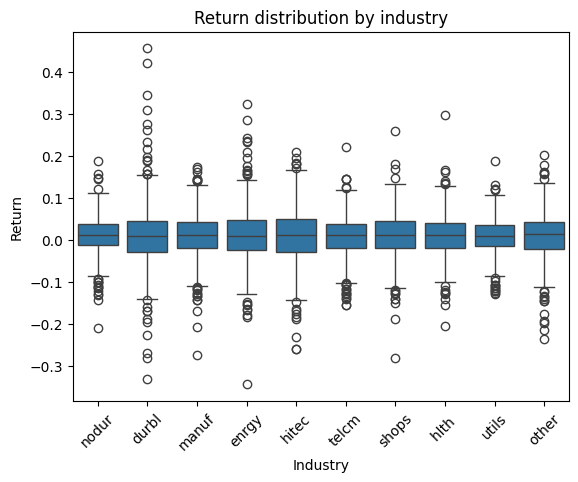

In [29]:
# display the distribution of the returns for the different industrie
sns.boxplot(x="industry", y="ret", data=data)
plt.ylabel("Return")
plt.xlabel("Industry")
plt.title("Return distribution by industry")
plt.xticks(rotation=45)
plt.show()


## Preprocessing

In [45]:
#import product
from itertools import product
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
macro_variables = data.filter(like="macro").columns
factor_variables = data.filter(like="factor").columns

# generate tuples of all possible combinations of macro and factor variables
column_combinations = list(product(macro_variables, factor_variables))

# create a list of all the product columns 
new_column_values = []
for macro_column, factor_column in column_combinations:
    new_column_values.append(data[macro_column] * data[factor_column])

# create a dataframe based on the product columns
column_names = [" x ".join(t) for t in column_combinations]
new_columns = pd.DataFrame(dict(zip(column_names, new_column_values)))

# add the new columns to the data
data = pd.concat([data, new_columns], axis=1)

# display the distribution of the returns for the different industrie
preprocessor = ColumnTransformer(
  transformers=[
    ("scale", StandardScaler(), [col for col in data.columns if col not in ["ret_excess", "month", "industry"]])
  ],
  remainder="drop",
  verbose_feature_names_out=False
)


In [47]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

lm_model = ElasticNet(
  alpha=0.007,
  l1_ratio=1, 
  max_iter=5000, 
  fit_intercept=False
)  

lm_pipeline = Pipeline([
  ("preprocessor", preprocessor),
  ("regressor", lm_model)
])

### Training data

In [81]:
training_industry = "manuf"
training_date = "2011-12-01"
data_manufacturing = data.query(f"industry == '{training_industry}'")
data_manufacturing = data_manufacturing.loc[:,~data_manufacturing.columns.duplicated()].copy() # remove duplicate columns
data_manufacturing_training = (data_manufacturing.query(f"month<'{training_date}'"))

lm_fit = lm_pipeline.fit(
  data_manufacturing_training, 
  data_manufacturing_training.get("ret_excess")
)

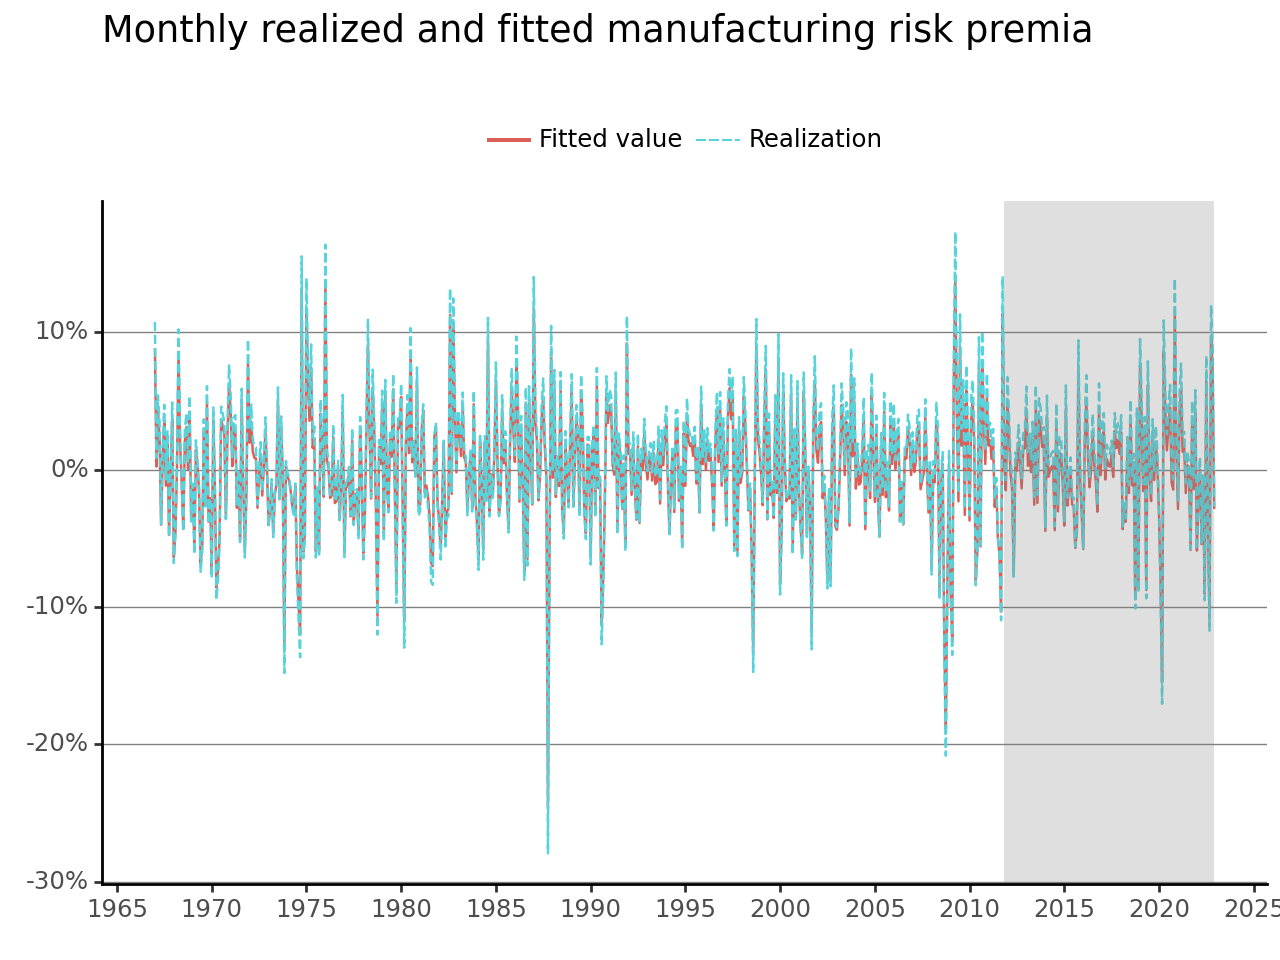

In [154]:
predicted_values = (pd.DataFrame({
    "Fitted value": lm_fit.predict(data_manufacturing),
    "Realization": data_manufacturing.get("ret_excess")
  })
  .assign(month = data_manufacturing["month"])
  .melt(id_vars="month", var_name="Variable", value_name="return")
)
predicted_values.sort_values(by=["month", "Variable"],ascending=[True, False], inplace=True)
# Compute residuals


predicted_values_plot = (
  ggplot(predicted_values, 
         aes(x="month", y="return", 
             color="Variable", linetype="Variable")) +
  geom_line() +
  annotate(
    "rect",
    xmin=data_manufacturing_training["month"].max(),
    xmax=data_manufacturing["month"].max(),
    ymin=-np.inf, ymax=np.inf,
    alpha=0.25, fill="#808080"
  ) + 
  labs(x="", y="", color="", linetype="",
       title="Monthly realized and fitted manufacturing risk premia") +
  scale_x_datetime(breaks=date_breaks("5 years"), 
                   labels=date_format("%Y")) +
  scale_y_continuous(labels=percent_format())
  + theme_classic()
  + theme(legend_position="top")
  # grid 
  + theme(panel_grid_major_y=element_line(color="grey", size=0.5))
)
predicted_values_plot.draw()

In [159]:
x = preprocessor.fit_transform(data_manufacturing)
y = data_manufacturing["ret_excess"]

alphas = np.logspace(-5, 5, 100)

coefficients_lasso = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False)
    coefficients_lasso.append(lasso.fit(x, y).coef_)
    
coefficients_lasso = (pd.DataFrame(coefficients_lasso)
  .assign(alpha=alphas, model="Lasso")
  .melt(id_vars=["alpha", "model"])
)
    
coefficients_ridge = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    coefficients_ridge.append(ridge.fit(x, y).coef_)

coefficients_ridge = (pd.DataFrame(coefficients_ridge)
  .assign(alpha=alphas, model="Ridge")
  .melt(id_vars=["alpha", "model"])
)

plotnine.ggplot.ggplot